In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

VERBOSE = False

# actions
ACTION_HIT = 0
ACTION_STICK = 1
ACTIONS = [ACTION_HIT, ACTION_STICK]
 
def get_card():
    '''
    cards are dealt from an infinite deck (i.e., with replacement)
    '''
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card


class Agent(object):
    def __init__(self, policy_type='simple'):
        self.reset_state()
        self.policy_type = policy_type
        self.init_policy()
        
    def init_policy(self):
        if self.policy_type == 'simple' or self.policy_type == 'monte_carlo_off_policy':
            self.policy = np.zeros(22)
            for i in range(12, 20):
                self.policy[i] = ACTION_HIT
            self.policy[20] = ACTION_STICK
            self.policy[21] = ACTION_STICK
        elif self.policy_type == 'monte_carlo_es':
            self.state_action_values = np.zeros((10, 10, 2, 2))
            self.state_action_pair_cnt = np.ones((10, 10, 2, 2)) # initialze counts to 1 to avoid 0 being divided
        
    def choose_action(self, target_policy=False, target_policy_state=None):
        if self.policy_type == 'simple':
            return self.policy[self.sum]
        elif self.policy_type == 'monte_carlo_es':
            state = [self.sum, self.dealer_card, self.usable_ace]
            state[0] -= 12
            state[1] -= 1
            state[2] = int(state[2])
            return np.argmax(self.state_action_values[state[0], state[1], state[2], :] / \
                             self.state_action_pair_cnt[state[0], state[1], state[2], :])
        elif self.policy_type == 'monte_carlo_off_policy' and target_policy == False:
            return np.random.choice(ACTIONS)
        elif self.policy_type == 'monte_carlo_off_policy' and target_policy == True:
            return self.policy[target_policy_state[0]]        
    
    def reset_state(self):
        self.sum = 0
        self.usable_ace = False
        self.dealer_card = 0
    

class Dealer(object):
    def __init__(self):
        self.reset_state()
     
    def choose_action(self):
        if self.sum >= 17:
            return ACTION_STICK
        else:
            return ACTION_HIT
        
    def reset_state(self):
        self.sum = 0
        self.usable_ace = False
        
def play(player, dealer, init_state=None, init_action=None):
    # reset state
    player.reset_state()
    dealer.reset_state()
    
    if init_state is None:
        # init cards of player
        while player.sum < 12:
            card = get_card()

            if card == 1 and player.sum + 11 <= 21:
                card = 11
                player.usable_ace = True

            player.sum += card
            if VERBOSE:
                print('player:', card, 'player.sum: %d -> %d' % (player.sum-card, player.sum))

        # init cards of dealer
        dealer_card_1 = get_card() # visible face value
        player.dealer_card = dealer_card_1
    else:
        player.sum = init_state[0]
        player.dealer_card = init_state[1]
        player.usable_ace = init_state[2]
        if VERBOSE:
            print('init state -- player.sum: %s, dealer_card: %s, player.usable_ace: %s' % tuple(init_state))
        dealer_card_1 = player.dealer_card
    
    if dealer_card_1 == 1 and dealer.sum + 11 <= 21:
        dealer_card_1 = 11
        dealer.usable_ace = True
    dealer.sum += dealer_card_1
    if VERBOSE:
        print('dealer:', dealer_card_1, 'dealer.sum: %d -> %d' % (dealer.sum-dealer_card_1, dealer.sum))

    dealer_card_2 = get_card() 
    if dealer_card_2 == 1 and dealer.sum + 11 <= 21:
        dealer_card_2 = 11
        dealer.usable_ace = True
    dealer.sum += dealer_card_2
    if VERBOSE:
        print('dealer:', dealer_card_2, 'dealer.sum: %d -> %d' % (dealer.sum-dealer_card_2, dealer.sum))   
    
    state = [player.sum, player.dealer_card, player.usable_ace]
    player_trajectory = []
        
    # player's turn 
    while True:
        if init_action is None:
            action = player.choose_action()
        else:
            action = init_action
            init_action = None
        
        player_trajectory.append([action, \
                                  (player.sum, player.dealer_card, player.usable_ace)])
        
        if action == ACTION_STICK: # ACTION: STICK
            if VERBOSE:
                print('player: stick')
            break
        else: # ACTION: HIT
            card = get_card()
            player.sum += card
            if VERBOSE:
                print('player:', card, 'player.sum: %d -> %d' % (player.sum-card, player.sum))

        # player goes bust
        if player.sum > 21: 
            if player.usable_ace:
                player.sum -= 10
                if VERBOSE:
                    print('player: soft hand; player.sum: %d -> %d' % (player.sum+10, player.sum))
                player.usable_ace = False
            else:
                if VERBOSE:
                    print('player goes bust')
                return state, -1, player_trajectory
            
    
    # dealer's turn
    while True:
        action = dealer.choose_action()
        if action == ACTION_STICK: # ACTION: STICK
            if VERBOSE:
                print('dealer: stick')
            break
        else: # ACTION: HIT
            card = get_card()
            dealer.sum += card
            if VERBOSE:
                print('dealer:', card, 'dealer.sum: %d -> %d' % (dealer.sum-card, dealer.sum))
        
        # dealer goes bust
        if dealer.sum > 21: 
            if dealer.usable_ace:
                dealer.sum -= 10
                if VERBOSE:
                    print('dealer: soft hand; dealer.sum: %d -> %d' % (dealer.sum+10, dealer.sum))
                dealer.usable_ace = False
            else:
                if VERBOSE:
                    print('dealer goes bust')
                return state, 1, player_trajectory
    
    
    # judge
    if player.sum > dealer.sum:
        return state, 1, player_trajectory
    elif player.sum == dealer.sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory


def monte_carlo_on_policy(n_episodes):
    player = Agent()
    dealer = Dealer()
    
    states_usable_ace = np.zeros((10, 10))
    states_usable_ace_cnt = np.ones((10, 10)) # initialze counts to 1 to avoid 0 being divided
    
    states_no_usable_ace = np.zeros((10, 10))
    states_no_usable_ace_cnt = np.ones((10, 10)) # initialze counts to 1 to avoid 0 being divided
    
    for i in xrange(0, n_episodes):
        state, reward, _ = play(player, dealer)
        
        state[0] -= 12
        state[1] -= 1
        if state[2]: # usable_ace
            states_usable_ace_cnt[state[0], state[1]] += 1
            states_usable_ace[state[0], state[1]] += reward
        else:
            states_no_usable_ace_cnt[state[0], state[1]] += 1
            states_no_usable_ace[state[0], state[1]] += reward
    return states_usable_ace/states_usable_ace_cnt,  \
        states_no_usable_ace/states_no_usable_ace_cnt


def monte_carlo_es(n_episodes):
    player = Agent(policy_type = 'monte_carlo_es')
    dealer = Dealer()

    for i in xrange(0, n_episodes):
        if i % 1000 == 0:
            print('episode:', i)
            
        # randomly init state and action for player
        init_state = [np.random.choice(range(12, 22)),
                      np.random.choice(range(1, 11)),
                      bool(np.random.choice([0, 1]))]
        
        init_action = np.random.choice(ACTIONS)
        if VERBOSE:
            print('init_action', init_action)

        _, reward, trajectory = play(player, dealer, init_state, init_action)
    
        for action, state in trajectory:
            state = list(state)
            state[0] -= 12
            state[1] -= 1
            state[2] = int(state[2])
            
            # update values of state-action pairs
            player.state_action_values[state[0], state[1], state[2], action] += reward
            player.state_action_pair_cnt[state[0], state[1], state[2], action] += 1

    return player.state_action_values / player.state_action_pair_cnt


def monte_carlo_off_policy(n_episodes):
    player = Agent(policy_type='monte_carlo_off_policy')
    dealer = Dealer()
    
    sum_of_reward = []
    sum_of_rho = []
    for i in xrange(0, n_episodes):
        if i % 1000 == 0:
            print('\tepisode:', i)
            
        # randomly init state and action for player
        init_state = [13, 2, True]
        
        _, reward, trajectory = play(player, dealer, init_state, init_action=None)
        
        # calc importance sampling ratio
        rho_above = 1.0
        rho_below = 1.0
        for action, state in trajectory:
            if action == player.choose_action(target_policy=True, target_policy_state=state):
                rho_below *= 0.5
            else:
                rho_above = 0.0
                break
        
        rho = rho_above/rho_below
        
        if i > 0:
            # don't forget to multiply the importance sampling ratio rho when calc rewards!
            sum_of_reward.append(sum_of_reward[-1]+rho*reward) 
            sum_of_rho.append(sum_of_rho[-1]+rho)
        else:
            sum_of_reward.append(rho*reward)
            sum_of_rho.append(rho)
    
    # we np.asarray() rather than np.array() because we don't want to make new copy of the array
    sum_of_reward = np.asarray(sum_of_reward) 
    sum_of_rho = np.asarray(sum_of_rho)
    ordinary_sampling = sum_of_reward / np.arange(1, n_episodes + 1)

    with np.errstate(divide='ignore', invalid='ignore'):
        weighted_sampling = np.where(sum_of_rho != 0, sum_of_reward / sum_of_rho, 0)

    return ordinary_sampling, weighted_sampling

    
def test_on_policy():
    '''
    learning the state-value function for a given policy:
        simply to average the returns observed after visits to that state
    The average should converge to the expected value as more returns are observed, 
    '''
    states_usable_ace, states_no_usable_ace = monte_carlo_on_policy(1000)
    plot_contour(states_usable_ace, 'Usable Ace, 10000 Episodes')
    plot_contour(states_no_usable_ace, 'No Usable Ace, 10000 Episodes')
    
def test_monte_carlo_es():
    state_action_value = monte_carlo_es(200000)
    
    # optimal policy and corresponding state value
    state_value_no_usable_ace = np.zeros((10, 10))
    state_value_usable_ace = np.zeros((10, 10))

    action_no_usable_ace = np.zeros((10, 10), dtype='int')
    action_usable_ace = np.zeros((10, 10), dtype='int')
    
    for i in range(10):
        for j in range(10):
            state_value_no_usable_ace[i, j] = np.max(state_action_value[i, j, 0, :])
            state_value_usable_ace[i, j] = np.max(state_action_value[i, j,1,  :])
            
            action_no_usable_ace[i, j] = np.argmax(state_action_value[i, j, 0, :])
            action_usable_ace[i, j] = np.argmax(state_action_value[i, j,1,  :])
    
    plot_contour(state_value_usable_ace, 'Optimal state value with usable Ace')
    plot_contour(state_value_no_usable_ace, 'Optimal state value with no usable Ace')
    plot_colormesh(action_usable_ace, 'Optimal policy with usable Ace' + '-- Action (0 Hit, 1 Stick)')
    plot_colormesh(action_no_usable_ace, 'Optimal policy with no usable Ace' + '-- Action (0 Hit, 1 Stick)')

    
def test_off_policy():
    '''
    The value of this state under the target policy is approximately  0.27726 
    (this was determined by separately generating one-hundred million episodes 
    using the target policy and averaging their returns)
    '''
    
    true_value = -0.27726
    n_episodes = 10000 # 10000
    n_runs = 100 #100
    ordinary_sampling = np.zeros(n_episodes)
    weighted_sampling = np.zeros(n_episodes)

    for i in range(0, n_runs):
        print('runs:', i)
        _ordinary_sampling, _weighted_sampling = monte_carlo_off_policy(n_episodes)
        # get the squared error
        ordinary_sampling += np.power(_ordinary_sampling - true_value, 2)
        weighted_sampling += np.power(_weighted_sampling - true_value, 2)
    ordinary_sampling /= n_runs
    weighted_sampling /= n_runs
    
    # plot figure
    axisX = np.log10(np.arange(1, n_episodes + 1))
    plt.plot(axisX, ordinary_sampling, label='Ordinary Importance Sampling')
    plt.plot(axisX, weighted_sampling, label='Weighted Importance Sampling')
    plt.xlabel('Episodes (10^x)')
    plt.ylabel('Mean square error')
    plt.legend()
    plt.show()


def plot_contour(data, title):
    plt.figure()
    plt.title(title)
    
    Z = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            Z[i][j] = data[i][j]
    
    X, Y = np.meshgrid(range(12, 22), range(1, 11), sparse=False, indexing='ij')
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=False)
    plt.xlabel('player sum')
    plt.ylabel('dealer showing')
    plt.show()
    

def plot_colormesh(data, title):
    plt.figure()
    plt.title(title)
    
    Z = np.zeros((10, 10))
    for i in range(10):
        for j in range(10):
            Z[i][j] = data[i][j]
    
    X, Y = np.meshgrid(range(12, 22), range(1, 11), sparse=False, indexing='ij')
    plt.pcolormesh(X,Y,Z)
    plt.xlabel('player sum')
    plt.ylabel('dealer showing')
    plt.show()
    

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':
/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':

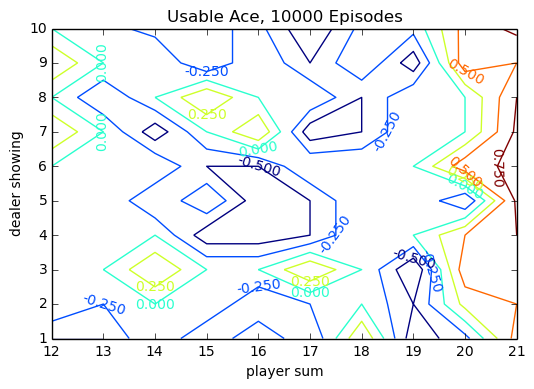

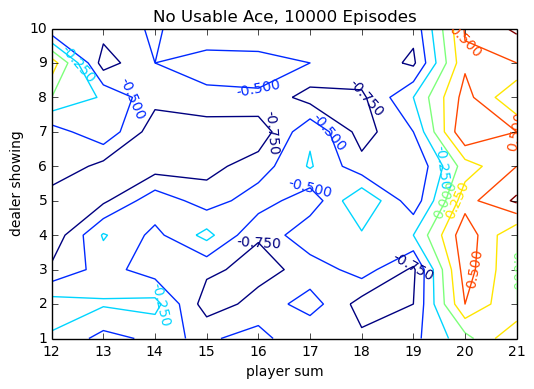

In [2]:
test_on_policy()

episode: 0
episode: 1000
episode: 2000
episode: 3000
episode: 4000
episode: 5000
episode: 6000
episode: 7000
episode: 8000
episode: 9000
episode: 10000
episode: 11000
episode: 12000
episode: 13000
episode: 14000
episode: 15000
episode: 16000
episode: 17000
episode: 18000
episode: 19000
episode: 20000
episode: 21000
episode: 22000
episode: 23000
episode: 24000
episode: 25000
episode: 26000
episode: 27000
episode: 28000
episode: 29000
episode: 30000
episode: 31000
episode: 32000
episode: 33000
episode: 34000
episode: 35000
episode: 36000
episode: 37000
episode: 38000
episode: 39000
episode: 40000
episode: 41000
episode: 42000
episode: 43000
episode: 44000
episode: 45000
episode: 46000
episode: 47000
episode: 48000
episode: 49000
episode: 50000
episode: 51000
episode: 52000
episode: 53000
episode: 54000
episode: 55000
episode: 56000
episode: 57000
episode: 58000
episode: 59000
episode: 60000
episode: 61000
episode: 62000
episode: 63000
episode: 64000
episode: 65000
episode: 66000
episode:

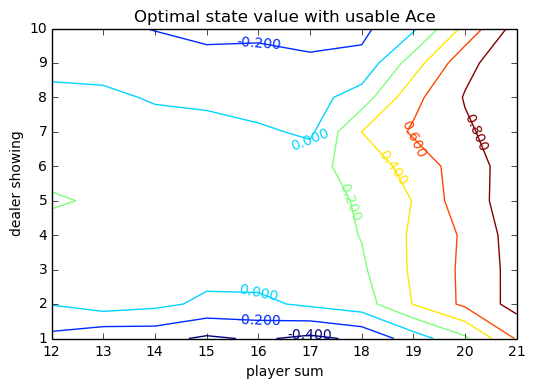

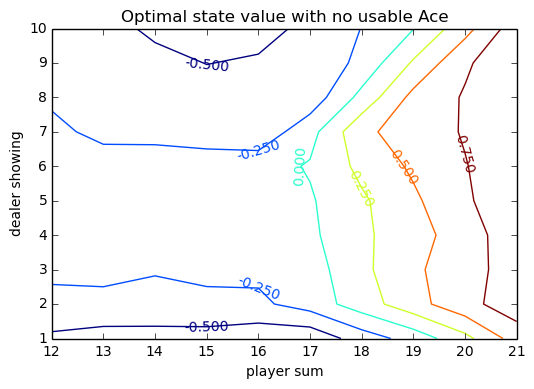

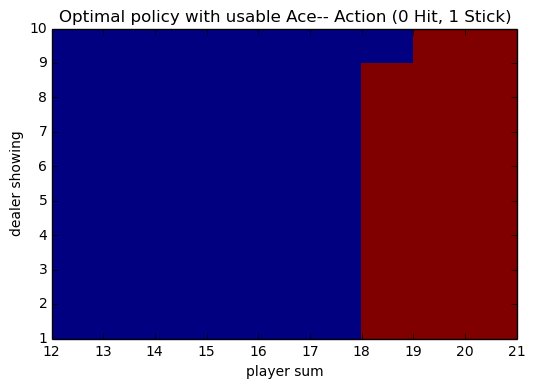

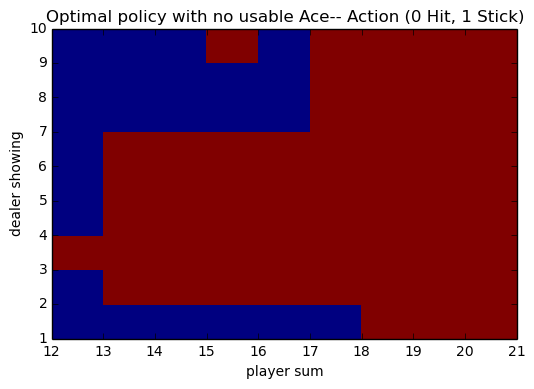

In [3]:
test_monte_carlo_es()

runs: 0
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 1
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 2
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 3
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 4
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 5
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 6
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	epis

	episode: 9000
runs: 53
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 54
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 55
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 56
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 57
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 58
	episode: 0
	episode: 1000
	episode: 2000
	episode: 3000
	episode: 4000
	episode: 5000
	episode: 6000
	episode: 7000
	episode: 8000
	episode: 9000
runs: 59
	episode: 0
	episode: 1000
	episode: 200

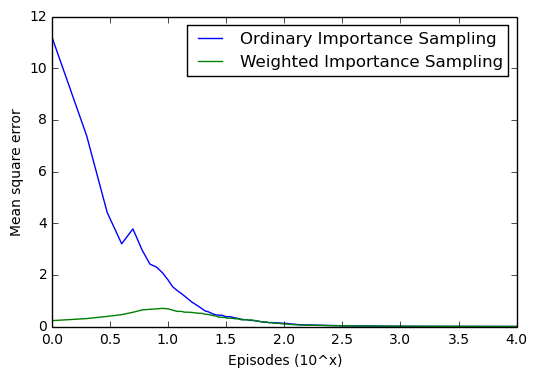

In [4]:
test_off_policy()